# Classifing hate speech tweets
## Using Multi-variate Bernoulli Naive Bayes and Multinominal Naive Bayes in combination with count vectorizer and TF-IDF vectorizer

### To Do's
- Modify Preprocessing (currently default count and TF-IDF vectroizer preprocessing used)
    - Implement Emoji transformation
    - Implement Morphological Normalization (e.g. Stemming)

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

e:\Programme\Miniconda\envs\DataMining\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\jonas\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)
100%|██████████| 1/1 [00:00<00:00, 501.59it/s]


In [4]:
df = pd.DataFrame.from_dict(dataset['train'])
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
# Currently not in use
def remove_punctioation(text:str) -> str:
    return "".join([i for i in text if i not in punctuation])

def tokenization(text:str) -> list:
    return nltk.word_tokenize(text)

def remove_stopwords(tokens) ->list:
    stopwords_list = stopwords.words("english")
    return [token for token in tokens if token not in stopwords_list]

porter_stemmer = PorterStemmer()

def stemming(text:list) -> list:
    return [porter_stemmer.stem(word) for word in text]

def preProcess(list):
    return list.apply(lambda x: stemming(remove_stopwords(tokenization(remove_punctioation(x.lower())))))

def preProcess2(list):
    return list.apply(lambda x: remove_stopwords(tokenization(remove_punctioation(x.lower()))))

def dummy(text):
    return text

def validate(y_test,y_pred):
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred))

In [ ]:
# Currently not in use
df["preprocessed"] = preProcess(df["tweet"])

In [33]:
df['no_user']= df['tweet'].str.replace("user","")

In [34]:
df.head()

,label,tweet,no_user
0,0,@user when a father is dysfunctional and is so...,@ when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,@ @ thanks for #lyft credit i can't use cause ...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


# Model Building

In [6]:
# Definition des Label-Vektors
y = df['label']

## Using TF-IDF Vectorizer

In [ ]:
'''# Using allready preprocessed tweets
tf = text.TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None)


X_vec = tf.fit(df['preprocessed'])
X = X_vec.transform(df['preprocessed'])

print(X.shape)'''

In [7]:
# Using unpreprocessed tweets
tf = text.TfidfVectorizer(stop_words='english')

X_vec = tf.fit(df['tweet'])
X = X_vec.transform(df['tweet'])

print(X.shape)

(31962, 41104)


In [7]:
tf.vocabulary_

{'user': 38161,
 'father': 12981,
 'dysfunctional': 11373,
 'selfish': 32080,
 'drags': 11051,
 'kids': 20140,
 'dysfunction': 11372,
 'run': 31207,
 'thanks': 35980,
 'lyft': 22203,
 'credit': 8964,
 'use': 38152,
 'cause': 6850,
 'don': 10839,
 'offer': 26115,
 'wheelchair': 39521,
 'vans': 38306,
 'pdx': 27319,
 'disapointed': 10458,
 'getthanked': 14989,
 'bihday': 4699,
 'majesty': 22413,
 'model': 23785,
 'love': 21856,
 'time': 36564,
 'urð': 38135,
 'factsguide': 12742,
 'society': 33470,
 'motivation': 24090,
 'huge': 17592,
 'fan': 12859,
 'fare': 12893,
 'big': 4637,
 'talking': 35449,
 'leave': 20907,
 'chaos': 7107,
 'pay': 27260,
 'disputes': 10579,
 'allshowandnogo': 2089,
 'camping': 6463,
 'tomorrow': 36788,
 'dannyâ': 9526,
 'school': 31755,
 'year': 40502,
 'exams': 12432,
 'think': 36335,
 'hate': 16540,
 'imagine': 18115,
 'actorslife': 1434,
 'revolutionschool': 30617,
 'girl': 15111,
 'won': 40020,
 'land': 20633,
 'allin': 2057,
 'cavs': 6863,
 'champions': 7065

In [ ]:
'''# No User string
# Definition der Feature-Matrix
tf = text.TfidfVectorizer(stop_words='english')

X_vec = tf.fit(df['no_user'])
X = X_vec.transform(df['no_user'])

print(X.shape)'''

### Splitting Data into train and test data

In [8]:
# Splitting of data into training and test data
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

In [9]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(y_train.count(), round(y_train.sum()/y_train.count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(y_test.count(), round(y_test.sum()/y_test.count()*100,2)))

There is 25569 training data, of which 7.02% is hate speech 
There is 6393 test data, of which 7.01% is hate speech 


### Train Models
The method GridSearchCV is used for hyperparameter optimization. In the following cases the smoothing parameter alpha is optimized.

In [12]:
from sklearn.model_selection import cross_validate
scores = cross_validate(nb.MultinomialNB(), X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.009974,0.000997,0.935080,0.940357
1,0.009973,0.001994,0.937622,0.940064
2,0.006981,0.002992,0.937427,0.940161
3,0.008976,0.000998,0.938600,0.940161
4,0.011968,0.001996,0.938588,0.940360


In [13]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-2, num=10)
}

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = ms.GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
gnb.fit(X_train.toarray(), y_train);

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train);
print('Scores with the Gaussian Naive Bayes:')
validate(y_test, gnb.predict(X_test.toarray()))

Scores with the Gaussian Naive Bayes:
Precision: 0.279
Recall: 0.618
Accuracy: 0.861
F1 Score: 0.384


In [20]:
from sklearn.naive_bayes import ComplementNB 
cnb = ms.GridSearchCV(nb.ComplementNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cnb.fit(X_train, y_train);
print('Scores with the Complement Naive Bayes:')
validate(y_test, cnb.predict(X_test))

Scores with the Complement Naive Bayes:
Precision: 0.583
Recall: 0.299
Accuracy: 0.936
F1 Score: 0.395


In [48]:
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(X_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(X_train, y_train);

In [47]:
mnb.best_params_

{'alpha': 0.19306977288832497}

### Evaluate Model Performance based on TF-IDF Vectorizer

In [42]:
print('Scores with the Multi-variate Bernoulli Naive Bayes:')
validate(y_test, bnb.predict(X_test))
print('Scores with the Multinominal Naive Bayes:')
validate(y_test, mnb.predict(X_test))

Scores with the Multi-variate Bernoulli Naive Bayes:
Precision: 0.524
Recall: 0.692
Accuracy: 0.934
F1 Score: 0.596
Scores with the Multinominal Naive Bayes:
Precision: 0.579
Recall: 0.623
Accuracy: 0.942
F1 Score: 0.600


In [32]:
print('Scores with the Multi-variate Bernoulli Naive Bayes:')
validate(y_test, bnb.predict(X_test))

Scores with the Multi-variate Bernoulli Naive Bayes:
Precision: 0.648
Recall: 0.551
Accuracy: 0.948
F1 Score: 0.596


In [36]:
print('Scores with the Multinominal Naive Bayes:')
validate(y_test, mnb.predict(X_test))

Scores with the Multinominal Naive Bayes:
Precision: 0.715
Recall: 0.542
Accuracy: 0.953
F1 Score: 0.617


In [ ]:
# Confusion-Matrix
cm = confusion_matrix(y_test, mnb.predict(X_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Using Count Vectorizer

In [ ]:
'''# No user string
co = text.CountVectorizer(stop_words='english')

Xc_vec = co.fit(df['no_user'])
Xc = Xc_vec.transform(df['no_user'])

print(Xc.shape)'''

In [13]:
co = text.CountVectorizer(stop_words='english')

Xc_vec = co.fit(df['tweet'])
Xc = Xc_vec.transform(df['tweet'])

print(Xc.shape)

(31962, 41104)


### Split Data

In [14]:
# Splitting of data into training and test data
(Xc_train, Xc_test, yc_train, yc_test) = ms.train_test_split(Xc, y, test_size=.2, random_state = 17)

### Train Models

In [15]:
# Multi-variate Bernoulli Naive Bayes
bnbc = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnbc.fit(Xc_train, yc_train);


# Multinominal Naive Bayes
mnbc = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnbc.fit(Xc_train, yc_train);

### Evaluate Model Performance based on Count Vectorizer

In [ ]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(yc_test, bnbc.predict(Xc_test))

In [ ]:
print('Scores with the multi-variate Bernoulli Naive Bayes:')
validate(yc_test, mnbc.predict(Xc_test))

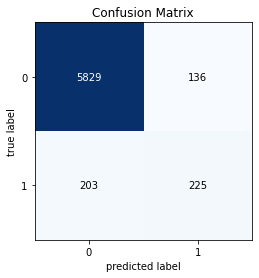

In [16]:
# Confusion-Matrix
cm = confusion_matrix(yc_test, mnbc.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()

# Analyze frequent words

In [ ]:
'''# Get most frequent words including stop words
word_freq_df = pd.DataFrame(Xc.toarray(), columns=co.get_feature_names_out())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head(10)'''

## Get words with biggest impact on each category

In [27]:
mnbc = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)}, cv = 10)

In [31]:
mnbc.fit(Xc_train, yc_train);
mnbc.cv_results_

{'mean_fit_time': array([0.00827768, 0.0090801 , 0.00837741, 0.00777957, 0.00658209,
        0.00658038, 0.00628736, 0.00628164, 0.0064934 , 0.00707979,
        0.00787921, 0.00718081, 0.00578334, 0.00588396, 0.00558722,
        0.00548553, 0.00598242, 0.00658259, 0.00639021, 0.00558195,
        0.00549109, 0.00548961, 0.0053865 , 0.00538852, 0.00548565,
        0.00538292, 0.00558481, 0.00578151, 0.00548532, 0.00528653,
        0.00569153, 0.00538533, 0.00548768, 0.00547748, 0.00528569,
        0.00537629, 0.00528812, 0.00557823, 0.00519068, 0.00508742,
        0.00558503, 0.00558329, 0.00568626, 0.00528252, 0.00528734,
        0.00557778, 0.00538344, 0.00528438, 0.0053884 , 0.00538929]),
 'std_fit_time': array([2.82252810e-03, 1.44145232e-03, 1.35327080e-03, 1.24582486e-03,
        1.35305666e-03, 1.01875514e-03, 6.33680841e-04, 8.98282213e-04,
        1.11566045e-03, 1.44163702e-03, 1.80893081e-03, 1.59610832e-03,
        7.39824725e-04, 2.99065721e-04, 6.59655043e-04, 6.69279155e-0

In [17]:
mnbc = nb.MultinomialNB()
mnbc.fit(Xc_train, yc_train);

In [ ]:
# Get words with biggest impact on each category

mnbc.feature_log_prob_
mnbc.coef_

feature_names = co.get_feature_names_out()
for i, class_label in enumerate(['no_hate', 'hate']):
    top10 = np.argsort(mnbc.feature_log_prob_[i])[-10:]
    print("%s: %s" % (class_label,
          " ".join(feature_names[j] for j in top10)))

# Upsample

In [ ]:
# Train vectorizer BEFORE upsampling
tf = TfidfVectorizer(stop_words='english')
X_tf_vec = tf.fit(df['tweet'])
#X_tf_vec = tf.fit(df['no_user'])

co = CountVectorizer(stop_words='english')
X_co_vec = co.fit(df['tweet'])
#X_co_vec = co.fit(df['no_user'])

In [ ]:
# Prepare Split data
y = df['label']
X = df['tweet']
#X = df['no_user']

In [ ]:
# Split data BEFORE upsampling
(X_train, X_test, y_train, y_test) = ms.train_test_split(X, y, test_size=0.2, random_state = 17, stratify=y)

df_train = pd.concat([y_train,X_train], axis=1)
df_test = pd.concat([y_test,X_test], axis = 1)
df_train.head()

In [ ]:
data_minority = df_train[df_train.label == 1]
data_majority = df_train[df_train.label == 0]

print("length majority", len(data_majority))
print("length minority", len(data_minority))

In [ ]:
from sklearn.utils import resample
data_minority = resample(data_minority, replace = True, n_samples=23775, random_state=55)

In [ ]:
df_train_up = pd.concat([data_majority, data_minority])
df_train_up.label.value_counts()

In [ ]:
'''# create embeddings

# tfifd
Xt_train = X_tf_vec.transform(df_train_up['no_user'])
Xt_test = X_tf_vec.transform(df_test['no_user'])

# count vectorizer
Xc_train = X_co_vec.transform(df_train_up['no_user'])
Xc_test = X_co_vec.transform(df_test['no_user'])

# labels
y_train = df_train_up['label']
y_test = df_test['label']

print(Xt_train.shape) '''

In [ ]:
# create embeddings

# tfifd
Xt_train = X_tf_vec.transform(df_train_up['tweet'])
Xt_test = X_tf_vec.transform(df_test['tweet'])

# count vectorizer
Xc_train = X_co_vec.transform(df_train_up['tweet'])
Xc_test = X_co_vec.transform(df_test['tweet'])

# labels
y_train = df_train_up['label']
y_test = df_test['label']

print(Xt_train.shape) 

In [ ]:
# Testing Stratification
print('There is {} training data, of which {}% is hate speech '.format(df_train_up['label'].count(), round(df_train_up['label'].sum()/df_train_up['label'].count()*100,2)))
print('There is {} test data, of which {}% is hate speech '.format(df_test['label'].count(), round(df_test['label'].sum()/df_test['label'].count()*100,2)))

In [ ]:
# TF-IDF
# Multi-variate Bernoulli Naive Bayes
bnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
bnb.fit(Xt_train, y_train);

# Multinominal Naive Bayes
mnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
mnb.fit(Xt_train, y_train);

In [ ]:
print('TF-IDF Scores with the multi-variate Bernoulli Naive Bayes:')
validate(y_test, bnb.predict(Xt_test))
print('TF-IDF Scores with the Multinominal Bernoulli Naive Bayes:')
validate(y_test, mnb.predict(Xt_test))

In [ ]:
# Count Vectorizer
# Multi-variate Bernoulli Naive Bayes
cbnb = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cbnb.fit(Xc_train, y_train);

# Multinominal Naive Bayes
cmnb = ms.GridSearchCV(nb.MultinomialNB(), param_grid={'alpha':np.logspace(-2., 2., 50)})
cmnb.fit(Xc_train, y_train);


In [ ]:
print('Count Vectorizer Scores with the multi-variate Bernoulli Naive Bayes:')
validate(y_test, cbnb.predict(Xc_test))
print('Count Vectorizer Scores with the Multinominal Bernoulli Naive Bayes:')
validate(y_test, cmnb.predict(Xc_test))

In [ ]:
# Confusion-Matrix
cm = confusion_matrix(y_test, cmnb.predict(Xc_test))

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.title("Confusion Matrix")
plt.show()